In [0]:
import torch
from torchvision import transforms

### Подготовка данных

In [0]:
from torchvision.datasets import FashionMNIST

In [0]:
_tasks = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [0]:
## Load MNIST Dataset and apply transformations
fashion_mnist = FashionMNIST('./Fashion_MNIST_data', download=True, train=True, transform=_tasks)

In [0]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [0]:
## create training and validation split 
split = int(0.8 * len(fashion_mnist))
index_list = list(range(len(fashion_mnist)))
train_idx, valid_idx = index_list[:split], index_list[split:]

In [0]:
## create sampler objects using SubsetRandomSampler
tr_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(valid_idx)

In [0]:
## create iterator objects for train and valid datasets
batch_size = 250
trainloader = DataLoader(fashion_mnist, batch_size=batch_size, sampler=tr_sampler)
validloader = DataLoader(fashion_mnist, batch_size=batch_size, sampler=val_sampler)

### Сплетаем сеть

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [0]:
class Model(nn.Module):
    def __init__(self, do_batchnorm=False, do_dropout=False, name='just NN'):
        super().__init__()

        self.name = name
        self.do_batchnorm = do_batchnorm
        self.do_dropout = do_dropout
        
        self.hidden1 = nn.Linear(28*28,128)
        if self.do_batchnorm:
            self.bn = nn.BatchNorm1d(128)
        self.hidden2 = nn.Linear(128, 64)        
        self.output = nn.Linear(64, 10)    
        
        self.optimizer = optim.SGD(self.parameters(), lr=0.01, weight_decay= 1e-6, momentum = 0.9, nesterov = True)        
  
    def forward(self, x):
        x = x.view(-1, 28*28)   # превратим тензор в матрицу "сколько_есть" х 28*28
                                # из (batch_size, 1, 28, 28) на (batch_size, 28*28)
        x = self.hidden1(x)
        x = torch.relu(x)
        if self.do_batchnorm:
            x = self.bn(x)
        
        x = self.hidden2(x)
        x = torch.relu(x)
        
        if self.do_dropout:
            x = F.dropout(x, 0.5) #доля нейронов, которые мы будем выключать
                
        x = self.output(x)
        x = torch.log_softmax(x, dim=1)
        
        return x

In [0]:
# варианты моделей с наворотами и без
model_simple = Model(name='simple')
model_bn = Model(do_batchnorm=True, name='batchnorm')
model_drop = Model(do_dropout=True, name='dropout')
model_bn_drop = Model(do_batchnorm=True, do_dropout=True,name='batchnorm+dropout')

### Определяем функцию потерь

In [0]:
loss_function = nn.NLLLoss() #negative log-likelihood loss

### Тренировка

In [0]:
# Возвращает число попаданий на проверочном наборе validloader
def get_accuracy(model, validloader):
    correct_count, all_count = 0, 0
  
    for data, target in validloader:
        for i in range(len(target)):
            img = data[i].view(1, 784)
            with torch.no_grad():
                log_prob = model(img)

            ps = torch.exp(log_prob)
            probab = list(ps.numpy()[0])
            pred_target = probab.index(max(probab))
            true_target = target.numpy()[i]
            
            if(true_target == pred_target):
                correct_count += 1
            all_count += 1

    accuracy = correct_count/all_count 
    
    return accuracy

In [0]:
# Строит графики
def show(loss_history, metrics_history, title):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))

    ax1.plot(loss_history['valid'], label='на проверочном наборе')
    ax1.plot(loss_history['train'], label='на обучающем наборе')
    ax1.grid()
    ax1.set_title(title)    
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(metrics_history['accuracy'], label='accuracy')
    ax2.grid()
    ax2.set_title(title) 
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Accuracy')
    ax2.legend();

In [0]:
# тренирует с отслеживанием показателей
def train_eval(N_epoch, model):
    print('Model %s :' % model.name)
    
    loss_history = {'train': [], 'valid': []}
    metrics_history = {'accuracy':[]}
    
    for epoch in range(1, N_epoch): ## run the model for series of epochs
        train_loss, valid_loss = [], []

        ## training part 
        model.train()
        for data, target in trainloader:
            model.optimizer.zero_grad()

            ## 1. forward propagation
            output = model(data)

            ## 2. loss calculation
            loss = loss_function(output, target)

            ## 3. backward propagation
            loss.backward()

            ## 4. weight optimization
            model.optimizer.step()

            train_loss.append(loss.item())

        loss_history['train'].append(np.mean(train_loss))

        ## evaluation part 
        model.eval()
        for data, target in validloader:
            output = model(data)
            loss = loss_function(output, target)
            valid_loss.append(loss.item())

        loss_history['valid'].append(np.mean(valid_loss))

        acc = get_accuracy(model, validloader)
        metrics_history['accuracy'].append(acc)

        print ("Epoch:", epoch, "Training Loss: ", np.mean(train_loss), "Valid Loss: ", np.mean(valid_loss), "Accuracy: ", acc)
            
    return (model, loss_history, metrics_history)

In [42]:
# Запускаем обучение сетей
history = []
for i, model in enumerate([model_simple, model_bn, model_drop, model_bn_drop ]):
    N_epochs = 31
    if i >= 2: 
      N_epochs = 51
      
    net, loss_history, metrics_history = train_eval(N_epochs,model)
    history.append({'net': net, 'loss': loss_history, 'metrics': metrics_history })

Model simple :
Epoch: 1 Training Loss:  0.7993124756030738 Valid Loss:  0.49178556725382805 Accuracy:  0.8255
Epoch: 2 Training Loss:  0.4510148855236669 Valid Loss:  0.4335368101795514 Accuracy:  0.8449166666666666
Epoch: 3 Training Loss:  0.4007050087675452 Valid Loss:  0.3920502172162135 Accuracy:  0.8598333333333333
Epoch: 4 Training Loss:  0.36807236859264475 Valid Loss:  0.3734871031095584 Accuracy:  0.86675
Epoch: 5 Training Loss:  0.3456495844293386 Valid Loss:  0.3581031331171592 Accuracy:  0.8728333333333333
Epoch: 6 Training Loss:  0.32759745450069505 Valid Loss:  0.34742436682184535 Accuracy:  0.87675
Epoch: 7 Training Loss:  0.3127117968009164 Valid Loss:  0.3433419307693839 Accuracy:  0.8764166666666666
Epoch: 8 Training Loss:  0.30007549142464995 Valid Loss:  0.3343049995601177 Accuracy:  0.8806666666666667
Epoch: 9 Training Loss:  0.2892039922686915 Valid Loss:  0.3266708916053176 Accuracy:  0.8820833333333333
Epoch: 10 Training Loss:  0.2766007258712004 Valid Loss:  0.

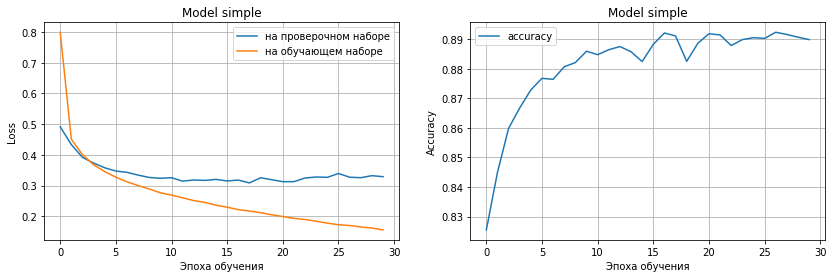

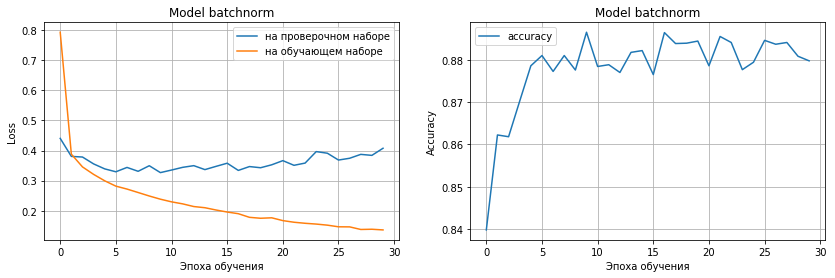

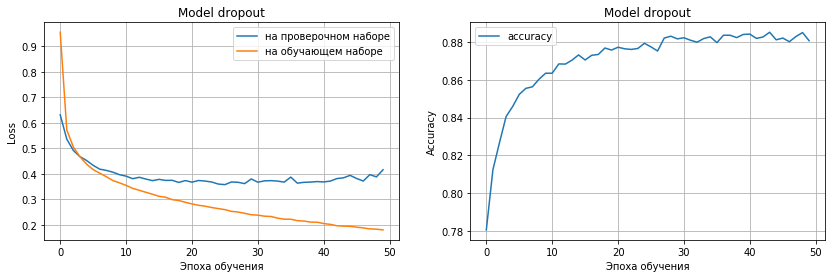

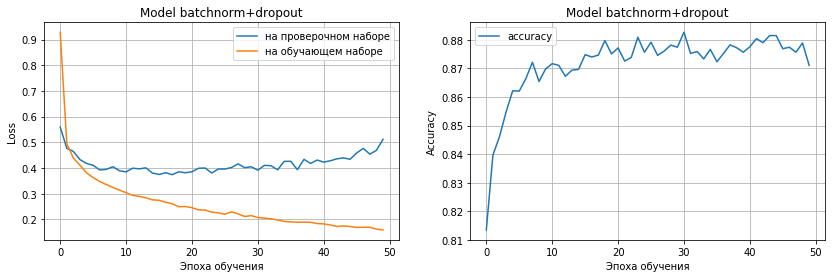

In [43]:
# vizualize in separate cell - for reader's comfort  
for way in history:
    show(way['loss'], way['metrics'], 'Model ' + way['net'].name)    

### Итоги

1. Сеть с dropout переобучаться начала вскоре после 20й эпохи. Добавление batchnorm ускорила процесс тренировки и начало переобучения сместилось в район 15й эпохи. При этом незначительно увеличилось лучшее достигнутое значение loss, а также возрос разброс значений по accuracy.

2. Сеть без применения нормирования по батчам и разреживания слоев показала лучший (наименьшей) loss. Переобучение наступило в районе 18й эпохи.